# DECEPTIVE REVIEW CLASSIFIER

In [130]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
import spacy
from spacy.util import minibatch
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn import metrics
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [132]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [133]:
df.shape

(1600, 5)

In [134]:
df['deceptive'].value_counts()

deceptive    800
truthful     800
Name: deceptive, dtype: int64

In [135]:
df['polarity'].value_counts()

positive    800
negative    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [136]:
df['hotel'].value_counts()

allegro             80
hardrock            80
swissotel           80
hyatt               80
conrad              80
knickerbocker       80
james               80
sofitel             80
hilton              80
fairmont            80
amalfi              80
palmer              80
monaco              80
affinia             80
talbott             80
ambassador          80
omni                80
intercontinental    80
homewood            80
sheraton            80
Name: hotel, dtype: int64

In [137]:
df['source'].value_counts()

MTurk          800
TripAdvisor    400
Web            400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

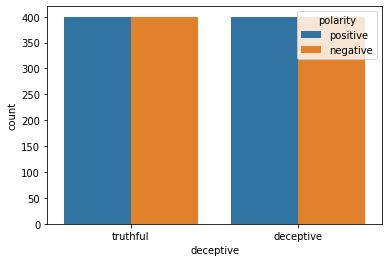

In [138]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

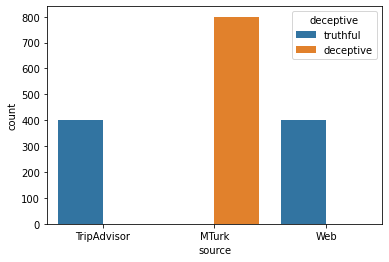

In [139]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [140]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [141]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [142]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [143]:
#z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
#df['deceptive'] = df['deceptive'].map(z)

In [144]:
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [145]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [146]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [147]:
x = df['text']
y = df['deceptive']

### TEXT AUGMENTATION USING SYNONYM REPLACEMENT

In [148]:
!pip install nlpaug

In [149]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
nltk.download('averaged_perceptron_tagger')

from nlpaug.util import Action

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [150]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)

In [151]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in x.index:
  if y[i]==0:
    temps=aug.augment(x[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(0)
  else :
    temps=aug.augment(x[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(1)

In [152]:
# after augumenting, our dataset is multiplied with 10 times.
x=x.append(pd.Series(augmented_sentences),ignore_index=True)
y=y.append(pd.Series(augmented_sentences_labels),ignore_index=True)

In [153]:
df1=pd.DataFrame({'review':x,'sentiment':y})
df1.head()

,review,sentiment
0,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",1
1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",1
2,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",1
3,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",1
4,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n",1


In [154]:
df1.shape

(17600, 2)

### DATA CLEANING USING SPACY

In [155]:
import string
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [156]:
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [157]:
# Creating a Spacy Parser
from spacy.lang.en import English
parser = English()
nlp=spacy.load("en_core_web_sm")

In [158]:
df1.shape

(17600, 2)

In [159]:
# Adding the built-in textcat component to the pipeline.
textcat=nlp.create_pipe( "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [160]:
# Adding the labels to textcat
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

1

In [161]:
# Converting the dataframe into a list of tuples
df1['tuples'] = df1.apply(lambda row: (row['review'],row['sentiment']), axis=1)
train =df1['tuples'].tolist()
train[:10]

[('We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n',
  1),
 ('Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n',
  1),
 ("This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend an

In [162]:
print(train[0])
print(len(train))

('We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n', 1)
17600


In [163]:
texts, labels = zip(*train)

In [164]:
texts[0]

'We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n'

In [165]:
labels[0]

1

In [166]:
cats = []
for y in labels:
    if(bool(y)):
        cats.append({"POSITIVE": True, "NEGATIVE":False})
    else:
        cats.append({"POSITIVE": False, "NEGATIVE":True})

In [167]:
TrainX = texts
TrainY = cats

In [168]:
n_texts=17600

In [169]:
len(TrainX)

17600

In [170]:
len(TrainY)

17600

In [171]:
train_data = list(zip(TrainX,[{'cats': cats} for cats in TrainY]))

In [172]:
train_data[0]

('We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n',
 {'cats': {'NEGATIVE': False, 'POSITIVE': True}})

In [173]:
n_iter=10

In [174]:
from spacy.util import minibatch, compounding

# Disabling other components
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    
    print("Training the model...")
    
    # Performing training
    for i in range(n_iter):
        print("Epoch : {} ".format(i))
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)

Training the model...
Epoch : 0 
Epoch : 1 
Epoch : 2 
Epoch : 3 
Epoch : 4 
Epoch : 5 
Epoch : 6 
Epoch : 7 
Epoch : 8 
Epoch : 9 


In [183]:
nlp.to_disk("sentiment")

In [184]:
nlp = spacy.load("sentiment")

In [185]:
# Testing the model
test_text = "bad hotel and aggressive staff"
doc=nlp(test_text)
doc.cats 

{'NEGATIVE': 0.9999252557754517, 'POSITIVE': 7.468153489753604e-05}